<a href="https://colab.research.google.com/github/aquibjaved/Bits_and_Pieces_DL/blob/tinytransformer/components_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import math

In [ ]:
class InputEmbeddings(nn.Module):
  def __init__(self, model_dim:int=512, vocab_size:int=30000):
    super().__init__()

    self.model_dim = model_dim
    self.vocab_size = vocab_size

    self.embedding = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.model_dim)

  def forward(self, x):
    return self.embedding(x) * math.sqrt(self.model_dim)


In [ ]:
emb = InputEmbeddings()

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, model_dim:int, seq_len:int, dropout:float):
    super().__init__()

    self.model_dim = model_dim
    self.seq_len= seq_len # max len of doc
    self.dropout = nn.Dropout(dropout)

    # create matrix of shape (seq, model_dim) => (512, 512)
    pe = torch.zeros(seq_len, model_dim)

    # create a vector for seq_len
    position = torch.arange(0, self.seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, model_dim, 2).float() * (-math.log(10000.0)/self.model_dim))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    pe = pe.unsqueeze(0)

    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
    return self.dropout(x)

In [ ]:
PE = PositionalEncoding(model_dim=512, seq_len=512, dropout=0.0)

In [ ]:
embd = [emb(torch.tensor(1)), emb(torch.tensor(2))]

In [ ]:
embeddings = []
for i in range(512):
  embeddings.append(emb(torch.tensor(i)))

In [ ]:
PE(torch.stack(embeddings))

tensor([[[ 35.5149, -15.7711,  16.9334,  ..., -32.3975,  40.1532,  21.5527],
         [-30.3600, -17.6613,  -8.8372,  ...,   3.7838,   5.3176, -14.4752],
         [  9.8720,   8.8738,  23.1288,  ..., -16.3057, -16.2766, -22.0833],
         ...,
         [ 25.0094, -20.8728, -24.1782,  ...,  13.0888, -36.0826, -30.3860],
         [ 12.5117,  37.2166,  -0.9132,  ...,  -8.9726,   8.0364,  -7.2092],
         [ -9.4687,  -3.1103, -38.7390,  ...,  -9.2633, -18.2889, -15.7000]]],
       grad_fn=<AddBackward0>)

In [ ]:
class LayerNormalization(nn.Module):
  def __init__(self, eps: float=10**-6):
    super().__init__()
    self.eps = eps
    self.alpha = nn.Parameter(torch.ones(1))
    self.bias = nn.Parameter(torch.zeros(1))

  def forward(self, x):
    mean = x.mean(dim = -1, keepdim=True)
    std = x.std(dim = -1, keepdim=True)

    return self.alpha * (x-mean)/(std+self.eps) + self.bias



In [ ]:
torch.zeros(1)

tensor([0.])

In [ ]:
class FeedForwardBlock(nn.Module):
  def __init__(self, model_dim:int, d_ff:int, dropout:float):
    super().__init__()

    self.d_ff = d_ff
    self.linear_one = nn.Linear(model_dim, self.d_ff)
    self.dropout = nn.Dropout(dropout)
    self.linear_out = nn.Linear(self.d_ff, model_dim)


  def forward(self, x):
    # (batch_size, max_seq_len, model_dim)

    return self.linear_two(self.dropout(torch.relu(self.linear_one(x))))


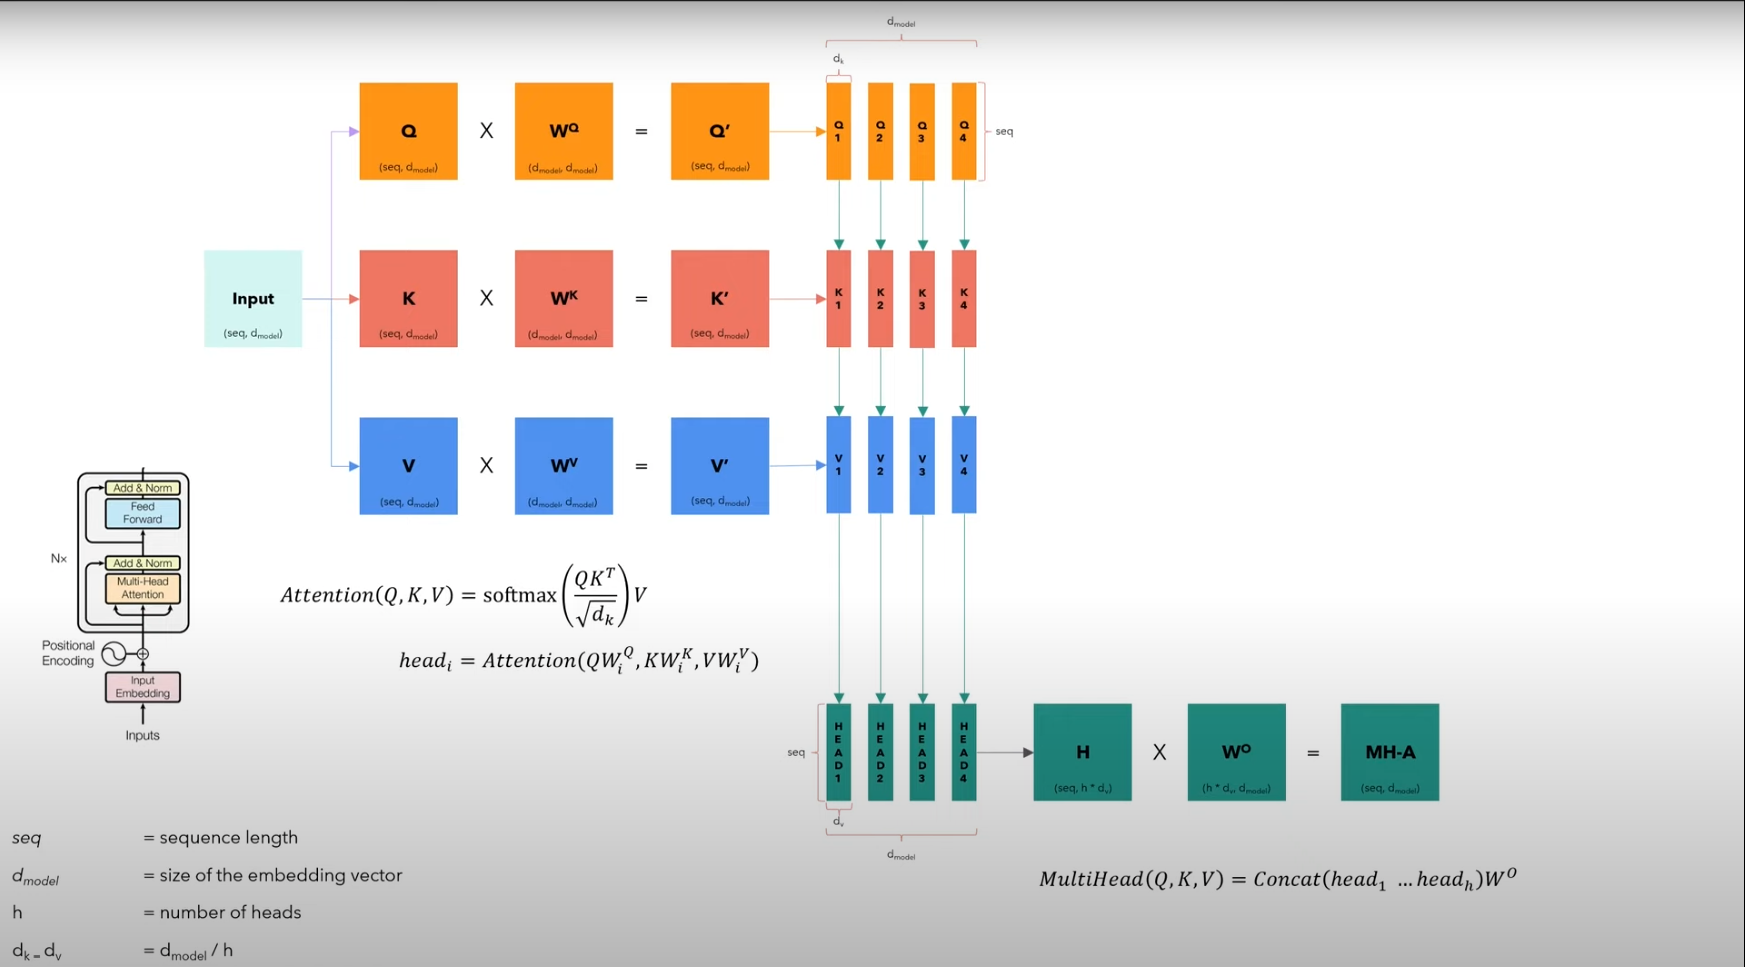

In [ ]:
from PIL import Image
from IPython.display import display

# Open an image file
img = Image.open('/content/abc.png') # Replace with your image path

# Display the image
display(img)


In [ ]:
class ResidualConnection(nn.Module):

        def __init__(self, features: int, dropout: float) -> None:
            super().__init__()
            self.dropout = nn.Dropout(dropout)
            self.norm = LayerNormalization(features)

        def forward(self, x, sublayer):
            return x + self.dropout(sublayer(self.norm(x)))

In [ ]:
class MultiHeadAttentionBlock(nn.Module):
  def __init__(self, h:int, model_dim:int, dropout:float):
    super().__init___()
    self.model_dim = model_dim
    self.h = h
    self.dropout = nn.Dropout(dropout)

    assert model_dim % h == 0
    self.d_k = model_dim//h

    # now get the weights of query, key, value
    self.w_q = nn.Linear(model_dim, model_dim)
    self.w_k = nn.Linear(model_dim, model_dim)
    self.w_v = nn.Linear(model_dim, model_dim)

    self.w_o = nn.Linear(model_dim, model_dim)

    self.dropout = nn.Dropout(dropout)

  @staticmethod
  def attention(query, key, value, mask, dropout: nn.Dropout):
    d_k = query.shape[-1]
    # Just apply the formula from the paper
    # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
    attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        # Write a very low value (indicating -inf) to the positions where mask == 0
        attention_scores.masked_fill_(mask == 0, -1e9)

    attention_scores = attention_scores.softmax(dim=-1) # (batch, h, seq_len, seq_len) # Apply softmax

    if dropout is not None:
        attention_scores = dropout(attention_scores)
    # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)
    # return attention scores which can be used for visualization
    return (attention_scores @ value), attention_scores

  def forward(self, q, k, v, mask):

    query = self.w_q(q)
    key = self.w_k(k)
    value = self.w_v(v)

    query = query.view(query.shape[0], query[1], self.h, self.d_k).transpose(1,2)
    key = value.view(key.shape[0], key[1], self.h, self.d_k).transpose(1,2)
    value = value.view(value.shape[0], value[1], self.h, self.d_k).transpose(1,2)

    # calculate attention
    x, self.attention_score = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

    # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
    x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

    # Multiply by Wo
    # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
    return self.w_o(x)




In [ ]:
class EncoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

In [ ]:
class Encoder(nn.Module):
  def __init__(self, layers:nn.ModuleList):
    super().__init__()
    self.layers = layers
    self.norm = LayerNormalization()

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return self.norm

In [ ]:
class DecoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

In [ ]:
class Decoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

In [ ]:
class ProjectionLayer(nn.Module):
  def __init__(self, model_dims:int, vocab_size:int):
    super().__init__()

    self.model_dims = model_dims
    self.vocab_size = vocab_size

    self.proj = nn.Linear(self.model_dims, self.vocab_size)

  def forward(self, x):
    return torch.log_softmax(self.proj(x), dim =-1)

In [ ]:
class Transformer(nn.Module):

    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        # (batch, seq_len, d_model)
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)

    def decode(self, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt: torch.Tensor, tgt_mask: torch.Tensor):
        # (batch, seq_len, d_model)
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    def project(self, x):
        # (batch, seq_len, vocab_size)
        return self.projection_layer(x)




In [ ]:
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int=512, N: int=6, h: int=8, dropout: float=0.1, d_ff: int=2048) -> Transformer:
    # Create the embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

    # Create the positional encoding layers
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

    # Create the encoder blocks
    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(d_model, encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    # Create the decoder blocks
    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(d_model, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)

    # Create the encoder and decoder
    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))

    # Create the projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

    # Create the transformer
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer